In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [5]:
# 데이터 로딩 및 전처리
digits = datasets.load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1437, 64) (1437,)
(360, 64) (360,)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [13]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
class DigitsMultiClassDNN(nn.Module):
    def __init__(self):
        super(DigitsMultiClassDNN, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)  # 10 클래스 분류
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
model = DigitsMultiClassDNN()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
train_losses = []
test_accuracies = []
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    # 테스트 정확도 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/30, Loss: 0.0009, Accuracy: 97.78%
Epoch 2/30, Loss: 0.0009, Accuracy: 97.78%
Epoch 3/30, Loss: 0.0008, Accuracy: 97.78%
Epoch 4/30, Loss: 0.0008, Accuracy: 97.78%
Epoch 5/30, Loss: 0.0008, Accuracy: 97.78%
Epoch 6/30, Loss: 0.0008, Accuracy: 97.78%
Epoch 7/30, Loss: 0.0007, Accuracy: 97.78%
Epoch 8/30, Loss: 0.0007, Accuracy: 97.78%
Epoch 9/30, Loss: 0.0007, Accuracy: 97.78%
Epoch 10/30, Loss: 0.0007, Accuracy: 97.78%
Epoch 11/30, Loss: 0.0007, Accuracy: 97.78%
Epoch 12/30, Loss: 0.0006, Accuracy: 97.78%
Epoch 13/30, Loss: 0.0006, Accuracy: 97.78%
Epoch 14/30, Loss: 0.0006, Accuracy: 97.78%
Epoch 15/30, Loss: 0.0006, Accuracy: 97.78%
Epoch 16/30, Loss: 0.0006, Accuracy: 97.78%
Epoch 17/30, Loss: 0.0006, Accuracy: 97.78%
Epoch 18/30, Loss: 0.0005, Accuracy: 97.78%
Epoch 19/30, Loss: 0.0005, Accuracy: 97.78%
Epoch 20/30, Loss: 0.0005, Accuracy: 97.78%
Epoch 21/30, Loss: 0.0005, Accuracy: 97.78%
Epoch 22/30, Loss: 0.0005, Accuracy: 97.78%
Epoch 23/30, Loss: 0.0005, Accuracy: 97.7

In [37]:
# 모델 평가
model.eval()

# 예측 및 라벨 저장용 리스트
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)  # 순전파
        _, predicted = torch.max(outputs.data, 1)  # 가장 높은 확률의 클래스 선택

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 리스트를 numpy 배열로 변환
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 혼동 행렬 및 기본 평가 지표 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Specificity 계산
specificity = []
with np.errstate(divide='ignore', invalid='ignore'):  # 0으로 나누는 경우 방지
    for i in range(conf_matrix.shape[0]):
        tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        specificity.append(spec)

# 결과
print("=== 모델 평가 결과 ===")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"F1 Score      : {f1:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"Specificity   : {np.mean(specificity):.4f}")

=== 모델 평가 결과 ===
Confusion Matrix:
[[27  0  0  0  0  0  0  0  0  0]
 [ 1 34  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 39  0  0  0  1]
 [ 0  1  0  0  0  0 43  0  0  0]
 [ 0  0  0  0  1  0  0 38  0  0]
 [ 0  1  0  1  0  0  0  0 37  0]
 [ 0  0  0  0  0  1  0  1  0 39]]
F1 Score      : 0.9778
Precision     : 0.9781
Recall        : 0.9778
Specificity   : 0.9975


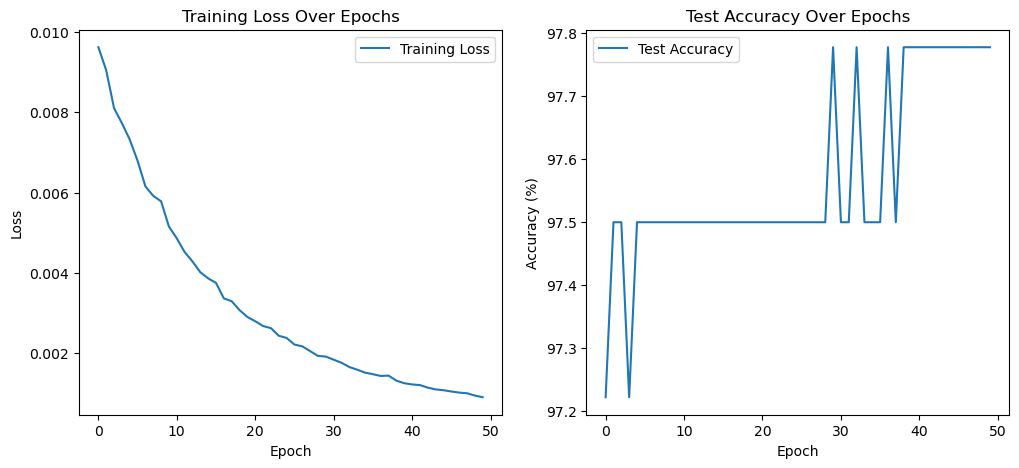

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()